In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt

## RF

In [ ]:
df = pd.read_csv("Train_data.csv")
df = df.dropna()  # must do
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30798 entries, 0 to 31042
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   LATITUDE     30798 non-null  float64
 1   LONGITUDE    30798 non-null  float64
 2   CTDPRS       30798 non-null  float64
 3   CTDTMP       30798 non-null  float64
 4   CTDSAL       30798 non-null  float64
 5   depth_m      30798 non-null  float64
 6   SA           30798 non-null  float64
 7   CT           30798 non-null  float64
 8   sound_speed  30798 non-null  float64
dtypes: float64(9)
memory usage: 2.3 MB


In [ ]:
X = df.drop(columns=["sound_speed"])
y = df.sound_speed
print(X.shape,y.shape)

(30798, 8) (30798,)


In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,shuffle=True,random_state=42,test_size=0.2)
X_train.shape,y_test.shape

((24638, 8), (6160,))

In [ ]:
rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=20,
    random_state=42,
    n_jobs=-1,
    oob_score=True
)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=200, n_jobs=-1, oob_score=True,
                      random_state=42)

In [ ]:
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

def evaluate(y_true, y_pred, label="Test"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"\n📊 {label} Results:")
    print(f"MAE: {mae:.3f}")
    print(f"RMSE: {rmse:.3f}")
    print(f"R²: {r2:.3f}")

evaluate(y_train, y_pred_train, "Train")
evaluate(y_test, y_pred_test, "Test")


📊 Train Results:
MAE: 0.123
RMSE: 0.558
R²: 0.999

📊 Test Results:
MAE: 0.328
RMSE: 1.486
R²: 0.996


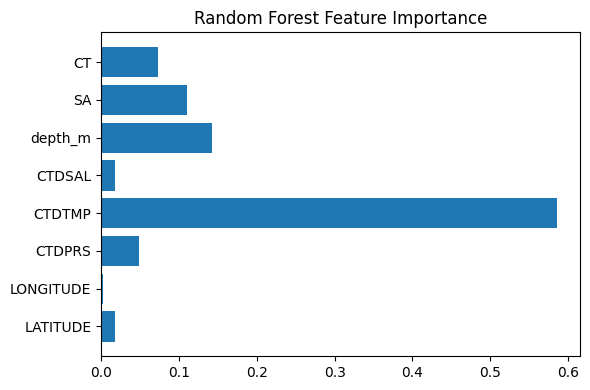

In [ ]:
plt.figure(figsize=(6, 4))
imp = rf.feature_importances_
plt.barh(X.columns, imp)
plt.title("Random Forest Feature Importance")
plt.tight_layout()
plt.show()

/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


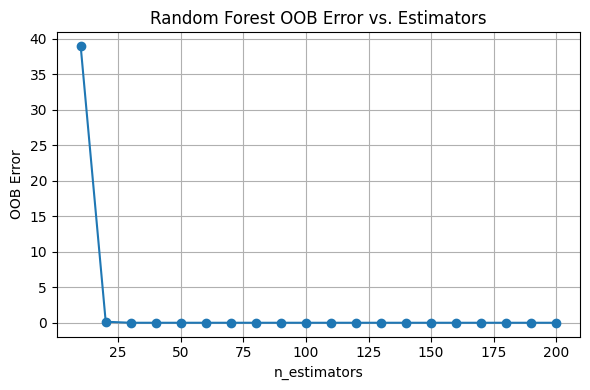

In [ ]:
# === “History” proxy: OOB error over n_estimators ===
# (Refit with warm_start to show decreasing OOB error)
errors = []
rf_ws = RandomForestRegressor(
    warm_start=True,
    n_estimators=1,
    max_depth=20,
    random_state=42,
    oob_score=True,
    n_jobs=-1
)
for i in range(10, 201, 10):
    rf_ws.n_estimators = i
    rf_ws.fit(X_train, y_train)
    errors.append(1 - rf_ws.oob_score_)

plt.figure(figsize=(6, 4))
plt.plot(range(10, 201, 10), errors, marker="o")
plt.title("Random Forest OOB Error vs. Estimators")
plt.xlabel("n_estimators")
plt.ylabel("OOB Error")
plt.grid(True)
plt.tight_layout()
plt.show()

## XGB

In [ ]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "eta": 0.1,
    "max_depth": 8,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "seed": 42
}

evals_result = {}
model = xgb.train(
    params,
    dtrain,
    num_boost_round=300,
    evals=[(dtrain, "train"), (dtest, "test")],
    evals_result=evals_result,
    verbose_eval=20
)


[0]	train-rmse:22.35223	test-rmse:22.33795
[20]	train-rmse:3.57758	test-rmse:4.28714
[40]	train-rmse:1.29197	test-rmse:2.93401
[60]	train-rmse:0.84974	test-rmse:2.77765
[80]	train-rmse:0.68227	test-rmse:2.81579
[100]	train-rmse:0.59873	test-rmse:2.83664
[120]	train-rmse:0.55887	test-rmse:2.85302
[140]	train-rmse:0.53466	test-rmse:2.86371
[160]	train-rmse:0.51124	test-rmse:2.87639
[180]	train-rmse:0.49568	test-rmse:2.87647
[200]	train-rmse:0.48392	test-rmse:2.86202
[220]	train-rmse:0.47461	test-rmse:2.87042
[240]	train-rmse:0.46709	test-rmse:2.87648
[260]	train-rmse:0.46562	test-rmse:2.84729
[280]	train-rmse:0.45566	test-rmse:2.83397
[299]	train-rmse:0.45307	test-rmse:2.82764


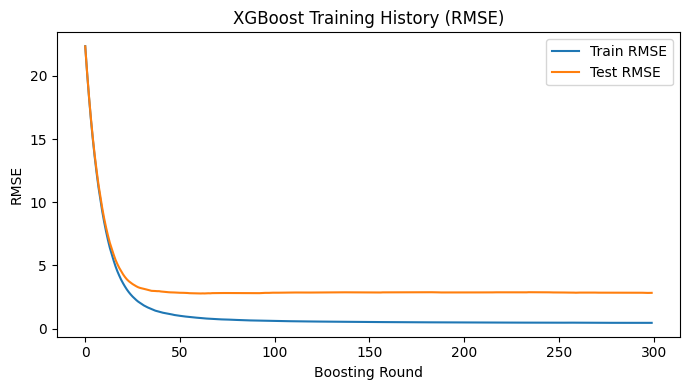

In [ ]:
plt.figure(figsize=(7, 4))
plt.plot(evals_result["train"]["rmse"], label="Train RMSE")
plt.plot(evals_result["test"]["rmse"], label="Test RMSE")
plt.title("XGBoost Training History (RMSE)")
plt.xlabel("Boosting Round")
plt.ylabel("RMSE")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# === Evaluate ===
y_pred_train = model.predict(dtrain)
y_pred_test = model.predict(dtest)

evaluate(y_train, y_pred_train, "Train")
evaluate(y_test, y_pred_test, "Test")


📊 Train Results:
MAE: 0.184
RMSE: 0.453
R²: 1.000

📊 Test Results:
MAE: 0.448
RMSE: 2.828
R²: 0.987


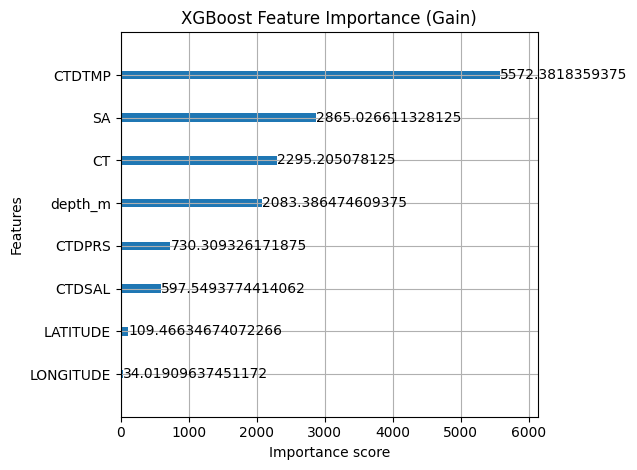

In [ ]:
# === Feature importance ===
xgb.plot_importance(model, importance_type="gain", max_num_features=10)
plt.title("XGBoost Feature Importance (Gain)")
plt.tight_layout()
plt.show()